# This is a Brain Tumor Segmentation Project using Unet

### Import Libraries

In [1]:
import torch
from trainer import Trainer
from visualize_results import plot_loss, plot_inference_result
from inference import inference
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [9]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

mask_path = "inference_images\59.png"
image_path = "inference_images\59.png"
mask = np.array(Image.open(mask_path).convert('L'))
image = np.array(Image.open(image_path).convert('L'))

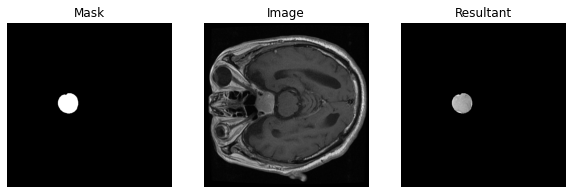

In [11]:
# Perform point-to-point multiplication
result = mask * image

# Plot the original arrays and the result
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot mask
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Mask')
axs[0].axis('off')

# Plot image
axs[1].imshow(image, cmap='gray')
axs[1].set_title('Image')
axs[1].axis('off')

# Plot the result
axs[2].imshow(result, cmap='gray')
axs[2].set_title('Resultant')
axs[2].axis('off')

plt.show()

In [12]:
import numpy as np
np.bool = np.bool_
import matplotlib.pyplot as plt
from skimage import measure
from skimage.measure import label, regionprops
from PIL import Image
from skimage.feature.texture import greycomatrix, greycoprops
%matplotlib inline

def extract_features(mask, result, pixel_spacing):
    # Compute perimeter
    label_img = label(mask, connectivity=mask.ndim)
    props = regionprops(label_img)
    perimeter_ = props[0].perimeter
    # perimeter_ = np.sum(perimeter(mask, neighbourhood = 4))

    # Compute other shape features
    # Compute area
    area = props[0].area

    # Compute convex area
    convex_area = measure.label(mask, background=0)

    # Compute solidity
    solidity = area / convex_area.max()

    # Compute circularity
    circularity = (4 * np.pi * area) / (perimeter_ ** 2)

    # Compute eccentricity
    props = measure.regionprops(mask.astype(int))
    eccentricity = props[0].eccentricity

    # Calculate tumor area in pixels
    # area = np.sum(mask)

    # Calculate tumor area in square millimeters
    pixel_spacing_x, pixel_spacing_y = pixel_spacing
    tumor_area_mm2 = area * pixel_spacing_x * pixel_spacing_y

    # Calculate equivalent diameter (optional)
    tumor_diameter_mm = np.sqrt(tumor_area_mm2 / np.pi)

        # Compute GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(result, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Compute GLCM properties
    contrast = greycoprops(glcm, 'contrast').flatten()
    energy = greycoprops(glcm, 'energy').flatten()
    homogeneity = greycoprops(glcm, 'homogeneity').flatten()
    
    # Combine texture features
    texture_features = np.concatenate((contrast, energy, homogeneity))

    # Return computed shape features
    return perimeter_, area, solidity, circularity, eccentricity, tumor_area_mm2, tumor_diameter_mm, texture_features


pixel_spacing = (0.938, 0.938)
perimeter_, area, solidity, circularity, eccentricity, tumor_area_mm2, tumor_diameter_mm, texture_features = extract_features(mask, result, pixel_spacing)

print("Perimeter:", perimeter_)
print("Area:", area)
print("Solidity:", solidity)
print("Circularity:", circularity) #0-1
print("Eccentricity:", eccentricity) #0-1
print("area in mm2: ", tumor_area_mm2)
print("diameter: ", tumor_diameter_mm)
print("texture_features: ", texture_features)


Perimeter: 207.82337649086284
Area: 3114
Solidity: 3114.0
Circularity: 0.9060239525456875
Eccentricity: 0.17942645789019962
area in mm2:  2739.8342159999997
diameter:  29.531615557862988
texture_features:  [19.47021007 26.42278484 17.05640747 26.67425446  0.98785337  0.98772998
  0.98785724  0.98773     0.99141594  0.99050799  0.99213586  0.99069353]


In [ ]:
inference()

### Pre Process Dataset

In [4]:
!python process_dataset.py

^C


### Train Model

In [2]:
trainer_obj = Trainer()

Best weights and optimizer parameters are loaded


In [ ]:
trainer_obj.setup_training_env()

In [ ]:
trainer_obj.train()

### Test Model

In [ ]:
trainer_obj.test()

### Save Results

In [ ]:
trainer_obj.save_results_to_csv()

### Plot Loss History

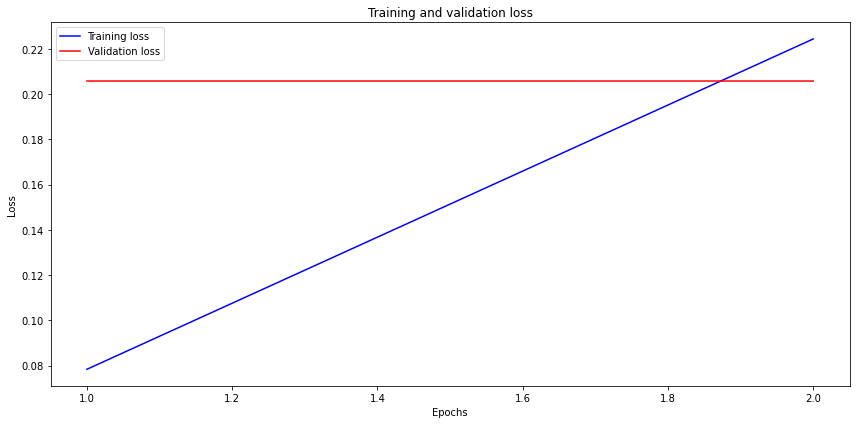

In [ ]:
%matplotlib inline
plot_loss()

### Visualize One Test Image and Mask

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
(512, 512) (512, 512)


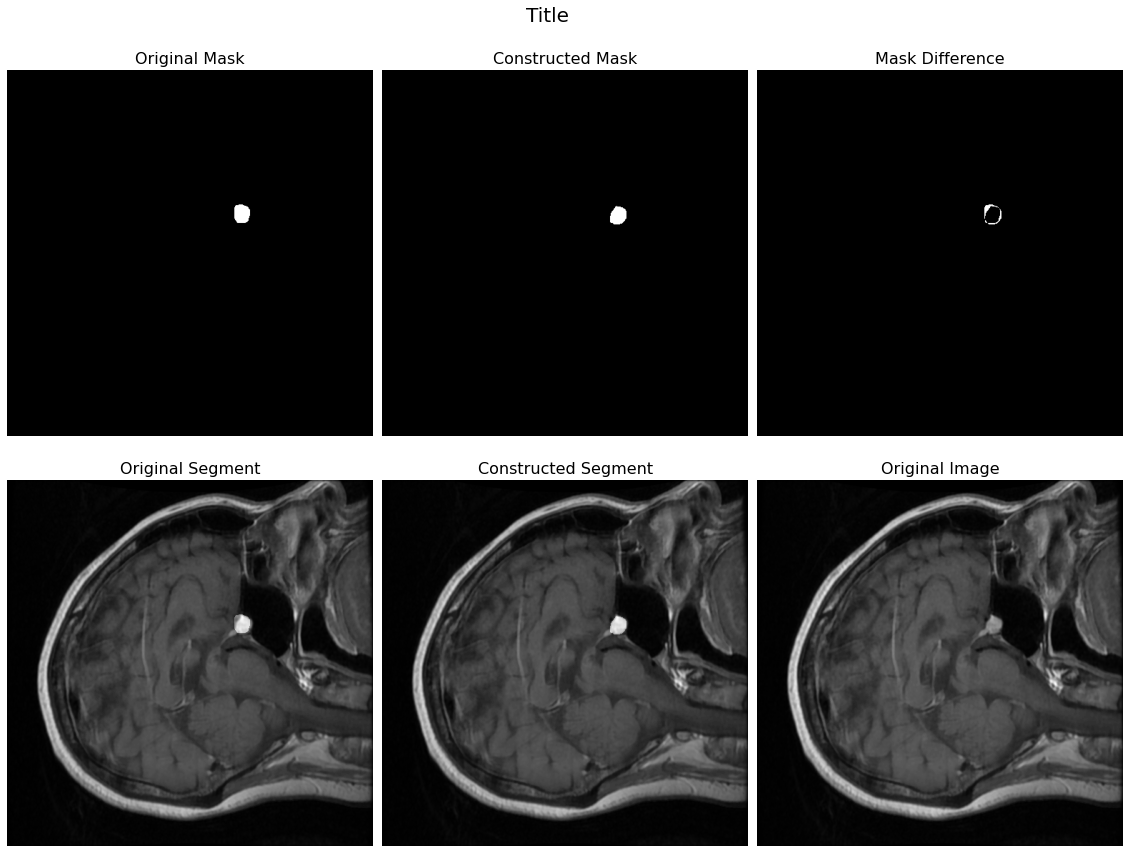

In [ ]:
from config import config
test_loader = trainer_obj.test_loader
model = trainer_obj.model
device = trainer_obj.device
checkpoint_path = config.pre_trained_model_path.joinpath('weights.pt')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()
with torch.no_grad():
    for image, mask in iter(test_loader):
        # image, mask = torch.tensor(image), torch.tensor(mask)
        image = image.to(device)
        # mask = mask.to(device)
        print(image.shape, mask.shape)
        model.to(device)
        output = model(image)
        output = (output > 0.2)
        output = output.squeeze().detach().cpu()
        mask = mask.squeeze().detach().cpu()
        image = image.squeeze().detach().cpu()
        output = output.numpy()
        image = image.numpy()
        mask = mask.numpy()
        print(image.shape, output.shape)
        plot_inference_result(image=image, mask=mask, output=output, title="Title")
        break

# This is Feature Extraction Part

### Do Inference, Convert Images to Masks

In [1]:
!python inference.py

^C


### Extract Features from Masks and Save Them

In [5]:
!python feature_extraction.py

something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened
something bad happened


feature_extraction.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  circularity = (4 * np.pi * area) / (perimeter_ ** 2)


### Train Classifier on Extracted Features

In [20]:
features_dataset = pd.read_csv('results\\features_dataset.csv')
# Calculate the average (mean) of the finite values in the 'circularity' column
finite_values = features_dataset['circularity'][np.isfinite(features_dataset['circularity'])]
avg_circularity = np.mean(finite_values)

# Replace infinite values with the average
features_dataset['circularity'] = features_dataset['circularity'].replace(np.inf, avg_circularity)
features_dataset

,perimeter_,area,solidity,circularity,eccentricity,tumor_area_mm2,tumor_diameter_mm,texture_features
0,6.000000,8,0.000079,2.792527,0.743017,7.038752,1.496831,[4.71608001e+03 4.98696058e+03 4.72817275e+03 ...
1,3.000000,5,0.000045,6.981317,0.732646,4.399220,1.183349,[5.24299752e+03 5.57003146e+03 5.19855141e+03 ...
2,0.000000,2,0.000017,2.788744,0.734161,1.759688,0.748416,[5.62962260e+03 5.93454135e+03 5.53652679e+03 ...
3,2.000000,4,0.000049,12.566371,0.822966,3.519376,1.058420,[4.38664262e+03 4.59867655e+03 4.31117626e+03 ...
4,4.000000,6,0.000076,4.712389,0.806644,5.279064,1.296294,[4.41597784e+03 4.61687896e+03 4.32387430e+03 ...
...,...,...,...,...,...,...,...,...
99,6.621320,8,0.000056,2.293035,0.405200,7.038752,1.496831,[8.04101287e+03 8.18295158e+03 8.02764021e+03 ...
100,7.207107,7,0.000052,1.693503,0.538618,6.158908,1.400158,[7.96524841e+03 8.15614573e+03 8.01468883e+03 ...
101,14.000000,16,0.000140,1.025826,0.674881,14.077504,2.116839,[7.89910312e+03 8.01826355e+03 7.89367347e+03 ...
102,0.000000,1,0.000009,2.788744,0.681226,0.879844,0.529210,[7.91915424e+03 8.05717984e+03 7.93739642e+03 ...


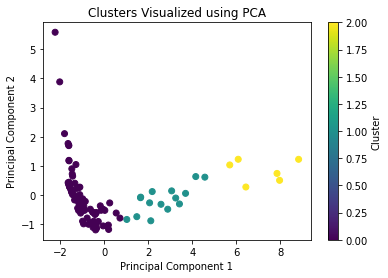

In [21]:
np.float = float 
import joblib
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset


# Separate features from the dataset
X = features_dataset.drop(columns=['texture_features'])

# Scale the features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters (K)
n_clusters = 3

# Initialize the KMeans clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the KMeans model to the scaled data
kmeans.fit(X_scaled)

# Predict the clusters for the data points
clusters = kmeans.predict(X_scaled)

# Add the cluster labels to the dataset
features_dataset['cluster'] = clusters

# Save the trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Evaluate the clustering model (if necessary)

# Visualize the clusters (if possible)
# For example, you can use PCA to reduce dimensionality and visualize in 2D or 3D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters Visualized using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [26]:
# features_dataset['cluster'].values_count()
features_dataset['cluster'].value_counts()


0    83
1    15
2     6
Name: cluster, dtype: int64

# Full Pipeline Segmentation + Classifier

In [ ]:
"""
load segmentation model
load classifier

pass image through segmentation model
get features
pass features through classifier

print final result
"""

In [ ]:
segmentation_obj = Trainer()

In [ ]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
model = segmentation_obj.model
model.to(segmentation_obj.device)
# checkpoint_path = config.model_weights_path.joinpath("best.pth")
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
# checkpoint_path = config.pre_trained_model_path.joinpath("weights.pt")
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
#     model.load_state_dict(checkpoint)
# else:
#     return "No Weights are Found"
transformation = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((config.image_size, config.image_size))
    ])
model.eval()
with torch.no_grad():
    image = Image.open("path")
    image1 = transformation(image)
    image1 = TF.to_tensor(image1)
    image1 = image1.unsqueeze(dim=0)
    image1 = image1.to(device)
    model.to(device)
    pred_mask = model(image1)
    pred_mask = (pred_mask > 0.5)

    pred_mask = pred_mask.squeeze().detach().cpu()
    pred_mask = pred_mask.numpy()
    mask1 = Image.fromarray(pred_mask)

    # image_name = str(image_name).split('\\')[-1]
    # img = TF.to_pil_image(image)
    # img = img.convert('L')

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plotting predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask1, cmap='gray')  # Assuming pred_mask is single-channel
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.suptitle(f'Image: inference')
    # plt.savefig(config.combined_image_mask.joinpath(image_name))
    plt.show()

### Get Input for Classifier

In [ ]:
mul = mask1 * image
pixel_spacing = (0.938, 0.938)
perimeter_, area, solidity, circularity, eccentricity,\
tumor_area_mm2, tumor_diameter_mm, texture_features = extract_features(mask1, mul, pixel_spacing)

print("Perimeter:", perimeter_)
print("Area:", area)
print("Solidity:", solidity)
print("Circularity:", circularity) #0-1
print("Eccentricity:", eccentricity) #0-1
print("area in mm2: ", tumor_area_mm2)
print("diameter: ", tumor_diameter_mm)
print("texture_features: ", texture_features)

In [ ]:
import joblib

# Load the saved model
kmeans_loaded = joblib.load('kmeans_model.pkl')

# Now, you can use the loaded model for inference on new data
# For example, if you have new data X_new, you can predict clusters as follows:
clusters_new = kmeans_loaded.predict(perimeter_, area, solidity, circularity, eccentricity,\
tumor_area_mm2, tumor_diameter_mm)

# Perform any further analysis or visualization using the loaded model
print(clusters_new)